In [4]:
import matplotlib.pyplot as plt

# importing Qiskit
from qiskit import IBMQ, QuantumCircuit, transpile
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel
import sys
import os
from helpers import get_error_rate
import numpy as np
from matplotlib.pyplot import figure
from IPython.display import display
import pickle

In [5]:
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-07-27 00:25:54,843: Credentials are already in use. The existing account in the session will be replaced.


In [6]:
hw_backend = provider.get_backend("ibmq_belem")
noise_model = NoiseModel.from_backend(hw_backend)
methods = ["statevector", "density_matrix", "matrix_product_state"]
sims = [AerSimulator(method=m,
                        noise_model=noise_model) for m in methods]

In [7]:
transpile_opts = {"optimization_level": 3, "seed_transpiler": 42}
backend_opts = {"shots": 10000, "seed_simulator": 42}

In [8]:
hw_config = hw_backend.configuration()

In [9]:
circuits = []
circuits_params = []

In [10]:
samples = np.linspace(0, 250, 21, dtype=int)[1:]*2

In [11]:
for i in range(hw_config.n_qubits):
	for sample in samples:
		qc = QuantumCircuit(5,5)
		for j in range(sample):
			qc.x(i)
			qc.barrier()
		qc.measure_all(add_bits=False)
		circuits.append(qc)
		circuits_params.append({"qubit": i, "number of x": sample})

In [12]:
transpiled_circuits_hw = transpile(circuits, hw_backend, **transpile_opts)
transpiled_circuits_sims = [transpile(circuits, sim, **transpile_opts) for sim in sims]

In [13]:
if os.path.isfile("hw_result.pickle"):
	with open("hw_result.pickle", "rb") as file:
		result_hw, noise_model = pickle.load(file)
else:
	result_hw = hw_backend.run(transpiled_circuits_hw, **backend_opts).result().get_counts()
	with open("hw_result.pickle", "wb") as file:
		pickle.dump((result_hw, noise_model), file)

In [14]:
results_sims = [sim.run(c, shots=10000).result().get_counts() for sim, c in zip(sims, transpiled_circuits_sims)]

In [15]:
results_hw_qubit = [[hw for hw, par in zip(result_hw, circuits_params) if par["qubit"] == i] for i in range(hw_config.n_qubits)]
results_sims_qubit = []
for res in results_sims:
	results_sims_qubit.append([[sim for sim, par in zip(res, circuits_params) if par["qubit"] == i] for i in range(hw_config.n_qubits)])
params_split = [[par for par in circuits_params if par["qubit"] == i] for i in range(hw_config.n_qubits)]

In [16]:
error_rates_hw_qubit = []
for res in results_hw_qubit:
	error_rates_hw_qubit.append([get_error_rate(hw, {"0"*hw_config.n_qubits: 1}) for hw in res])
error_rates_hw_qubit = np.array(error_rates_hw_qubit)
error_rates_sims_qubit = []
for results_sim_qubit in results_sims_qubit:
	error_rates_sim_qubit = []	
	for res in results_sim_qubit:
		error_rates_sim_qubit.append([get_error_rate(sim, {"0"*hw_config.n_qubits: 1}) for sim in res])
	error_rates_sims_qubit.append(error_rates_sim_qubit)
error_rates_sims_qubit = np.array(error_rates_sims_qubit)

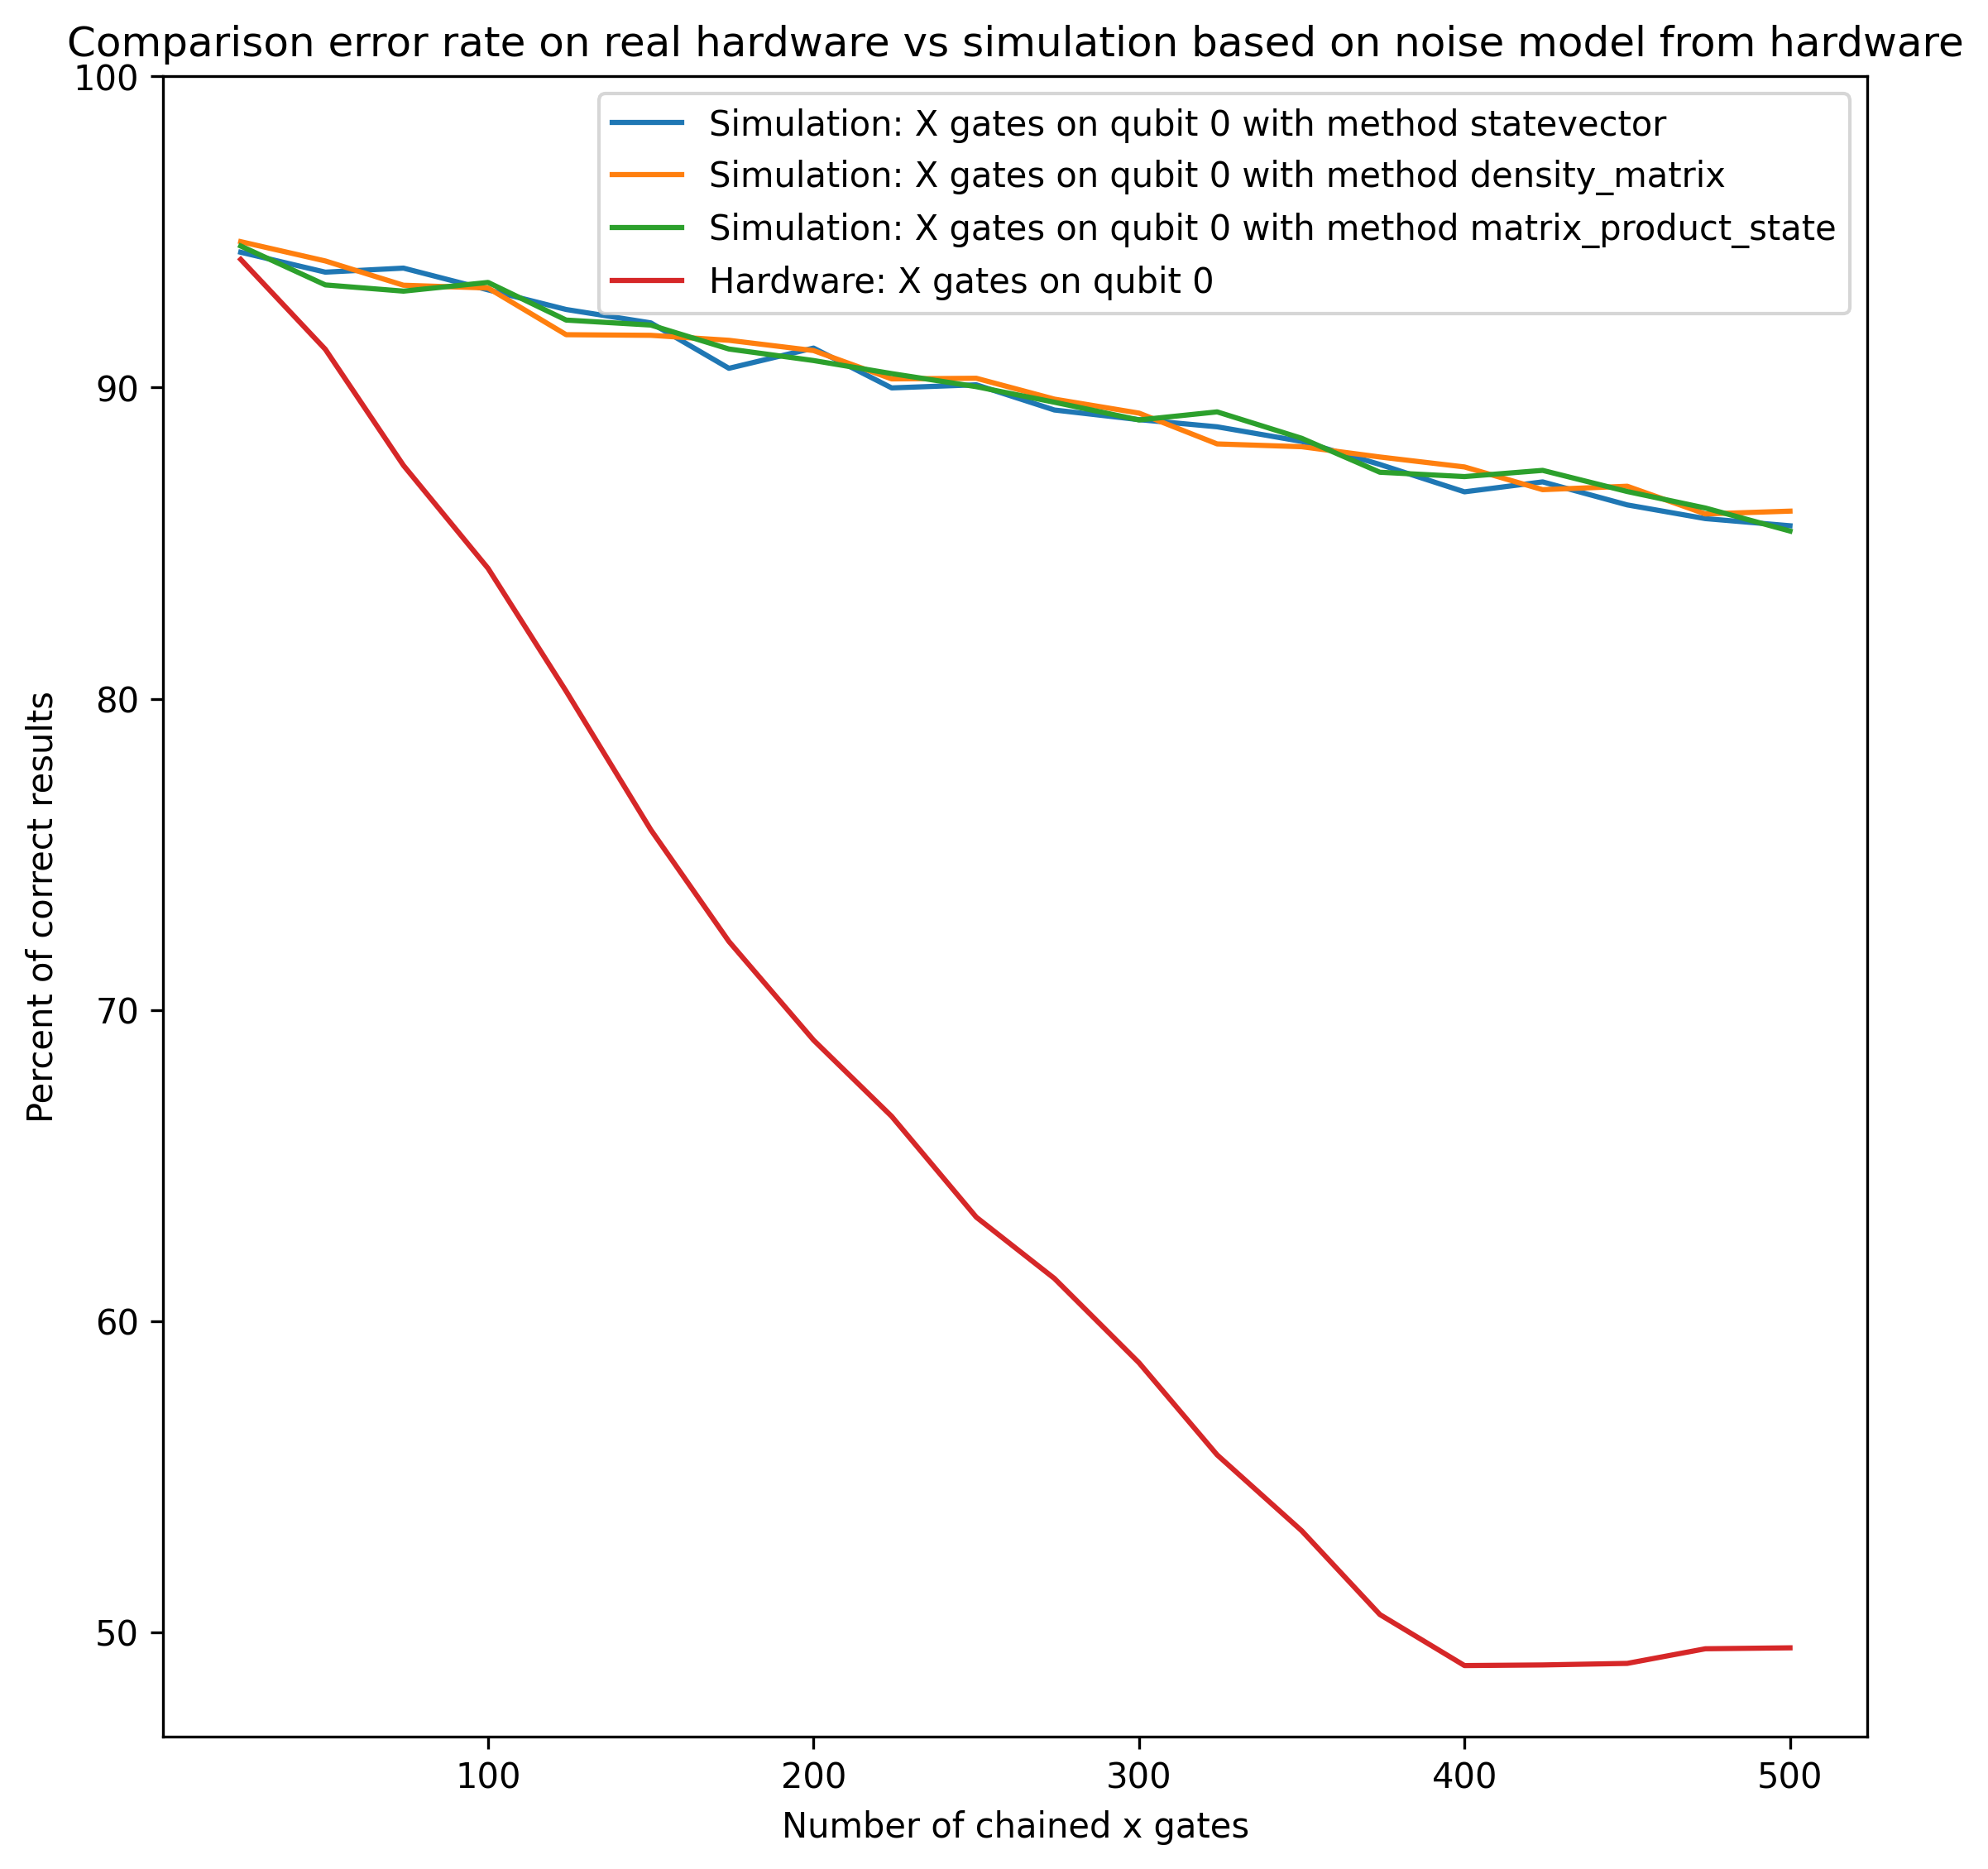

None

In [17]:
factor = 3
figure_width = 5.90666*factor/2
figure_heigth = figure_width
dpi = 300
for i in range(hw_config.n_qubits):
	figure(figsize=(figure_width, figure_heigth), dpi=dpi)
	for error_rates_sim_qubit, sim_name in zip(error_rates_sims_qubit, methods):
		plt.plot(samples, error_rates_sim_qubit[i, :]*100, label=f"Simulation: X gates on qubit {i} with method {sim_name}")
	plt.plot(samples, error_rates_hw_qubit[i, :]*100, label=f"Hardware: X gates on qubit {i}")
	plt.legend()
	plt.title("Comparison error rate on real hardware vs simulation based on noise model from hardware")
	plt.xlabel("Number of chained x gates")
	plt.ylabel("Percent of correct results")
	plt.ylim(top=100)
	plt.savefig("../images/sim_vs_hw.png", bbox_inches='tight')
	display(plt.show())
	break